In [1]:
import torch
import cv2
import numpy as np
import pytesseract
from ultralytics import YOLO
import  matplotlib.pyplot  as plt

# YOLOv8 모델 로드
model = YOLO('yolov8s.pt')  # 사전 훈련된 YOLOv8s 모델 로드

# 이미지 로드
img = cv2.imread('~~~~~~')

# 이미지 전처리 (BGR에서 RGB로 변환)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 객체 탐지 수행
results = model(img_rgb)

# 결과 처리
detections = results[0].boxes  # 첫 번째 결과에서 boxes 접근
boxes = detections.xyxy.cpu().numpy()  # [x1, y1, x2, y2, confidence, class]

# 형광펜 노란색 범위 설정 (HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# BGR을 HSV로 변환
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 노란색 영역 마스크 생성
mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

# 윤곽선 찾기
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# OCR을 위한 텍스트 저장 리스트
detected_texts = []

# OCR 수행
for contour in contours:
    if cv2.contourArea(contour) > 50:  # 최소 면적
        x, y, w, h = cv2.boundingRect(contour)
        roi = img[y:y+h, x:x+w]  # 관심 영역 추출

        # OCR 수행
        text = pytesseract.image_to_string(roi, lang='eng')  # 언어 설정
        if text.strip():  # 텍스트가 비어있지 않은 경우만 추가
            detected_texts.append(text.strip())  # 텍스트를 리스트에 추가

        # 바운딩 박스 그리기
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 바운딩 박스 그리기 (YOLO 탐지 결과)
for *box, conf, cls in detections:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # YOLO 탐지 바운딩 박스 색상 변경
    cv2.putText(img, f'{model.names[int(cls)]} {conf:.2f}', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


# 감지된 텍스트 출력
if detected_texts:  # 감지된 텍스트가 있을 경우만 출력
    for i, text in enumerate(detected_texts):
        print(f'Detected text {i + 1}: {text}')
else:
    print("No text detected.")



0: 448x640 (no detections), 99.3ms
Speed: 1.7ms preprocess, 99.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Detected text 1: overestimates
Detected text 2: soothes
Detected text 3: wound
Detected text 4: deliberate
Detected text 5: constitutes
Detected text 6: restraint.
Detected text 7: distinction
Detected text 8: curb


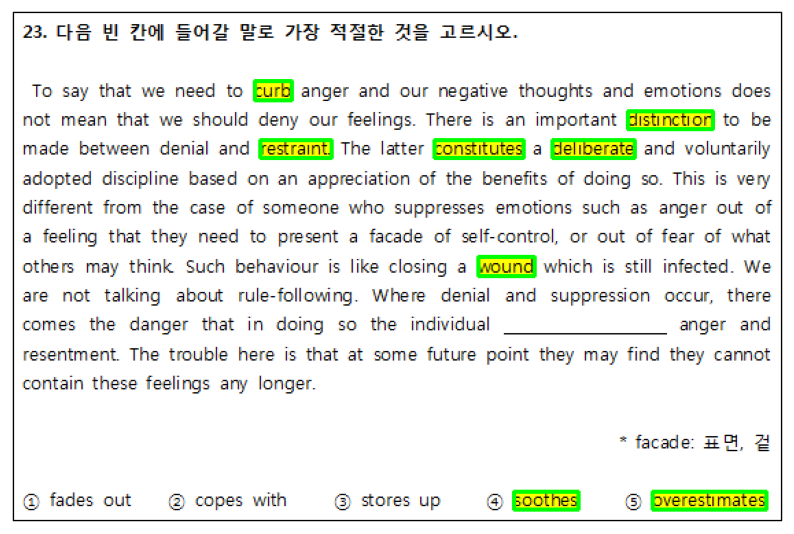

In [2]:
# 결과 이미지를 Matplotlib로 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
plt.axis('off')  # 축 숨기기
plt.show()